In [1]:
import pandas as pd
import seaborn as sns
import string
import re
import contractions
import torch
import math
from transformers import AutoTokenizer, T5ForConditionalGeneration, Adafactor
from tqdm.auto import tqdm

# DATA_PATH = '/content/gdrive/MyDrive/TweetQA/'
DATA_PATH = ''

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load dataset

In [2]:
train = pd.read_json(DATA_PATH+'data/train.json')
train = train.drop('qid', axis=1)
dev = pd.read_json(DATA_PATH+'data/dev.json')
dev = dev.drop('qid', axis=1)

train.head(10)

,Question,Answer,Tweet
0,at which school were first responders on the s...,[independence high school],"Our prayers are with the students, educators &..."
1,what website is linked in the tweet?,[instagram],I can finally say it out loud and proud: I'm g...
2,when does he say kaine is able?,"[5:09 pm- jul 22, 2016.]",KAINE IS ABLE!!!— Cory Booker (@CoryBooker) Ju...
3,what is up to us to keep doing?,[exploring],Cassini showed us the beauty of Saturn. It rev...
4,where can you see girls doing that?,[at the bar],"Nicki your video was just you twerking, I see ..."
5,who did they kil on tape,[eric],"Sean Abbott - thinking about you too, mate!— K..."
6,kaine took hundreds of thousands of dollars in...,[gifts],Is it the same Kaine that took hundreds of tho...
7,who say he's gay because he watches rupaul's d...,[andrew garfield],Andrew Garfield says he's gay because he watch...
8,what kind of contract did he have?,[a non-guaranteed contract],The Cavs have released Edy Tavares. No surpris...
9,what will senator rand paul do if he keeps oba...,[tax it],Shorter Obama: If you like your college saving...


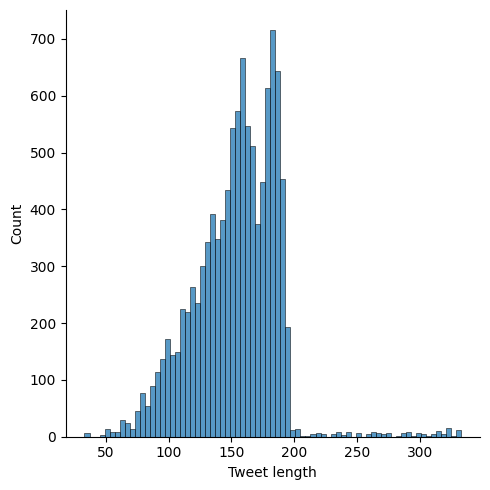

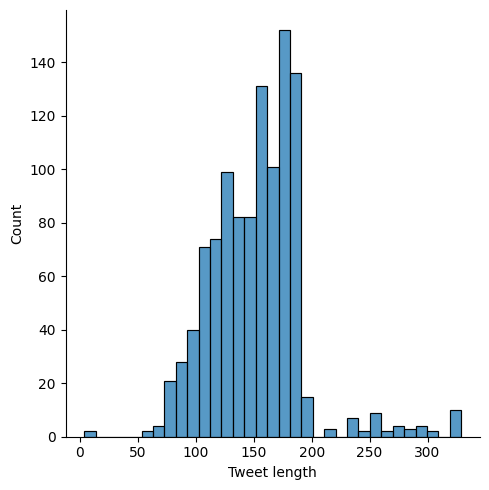

In [3]:
train['Tweet length'] = train.Tweet.apply(len)
sns.displot(train, x='Tweet length')

dev['Tweet length'] = dev.Tweet.apply(len)
sns.displot(dev, x='Tweet length')

## Preprocessing

In [4]:
def preprocessing(text):
    # Remove URLS
    text = re.sub(r"http\S+", "", text)

    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuations
    punctuationFree = []
    for i in text:
        if i not in string.punctuation:
            punctuationFree.append(i)
        else:
            punctuationFree.append(' '*len(i))
    punctuationFree = ''.join(punctuationFree)
    text = punctuationFree.strip()

    # Using contractions.fix to expand the shortened words
    expanded_words = []   
    for word in text.split():
        expanded_words.append(contractions.fix(word))  

    return text.lower()

In [5]:
train['Tweet'] = train['Tweet'].apply(lambda x: preprocessing(x))
dev['Tweet'] = dev['Tweet'].apply(lambda x: preprocessing(x))

## Training

In [6]:
tokenizer = AutoTokenizer.from_pretrained('google/byt5-base')
model = T5ForConditionalGeneration.from_pretrained('google/byt5-base', return_dict=True)

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(384, 1536)
  (encoder): T5Stack(
    (embed_tokens): Embedding(384, 1536)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1536, out_features=768, bias=False)
              (k): Linear(in_features=1536, out_features=768, bias=False)
              (v): Linear(in_features=1536, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=1536, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1536, out_features=3968, bias=False)
              (wi_1): Linear(in_features=1536, out_features=3968, bias=False)
              (

In [7]:
optimizer = Adafactor(model.parameters(),lr=1e-3,
                      eps=(1e-30, 1e-3),
                      clip_threshold=1.0,
                      decay_rate=-0.8,
                      beta1=None,
                      weight_decay=0.0,
                      relative_step=False,
                      scale_parameter=False,
                      warmup_init=False)

In [8]:
num_epoch = 3
batch_size = 10
num_of_batches = math.ceil(len(train)/batch_size)

model.train()
for epoch in tqdm(range(num_epoch), desc=f"Training progress", colour="#00ff00"):
    running_loss=0
    for i in tqdm(range(num_of_batches), leave=False, desc=f"Epoch {epoch + 1}/{num_epoch}", colour="#005500"):
        inputbatch=[]
        labelbatch=[]
        
        new_df = train[i*batch_size:i*batch_size+batch_size]
        for indx,row in new_df.iterrows():
            input = 'question: %s context: %s' % (row['Question'], row['Tweet'])
            labels = row['Answer'][0]  
            inputbatch.append(input)
            labelbatch.append(labels)

        inputbatch = tokenizer(inputbatch, padding='max_length', max_length=200, truncation=True, return_tensors='pt')["input_ids"]
        labelbatch = tokenizer(labelbatch, padding='max_length', max_length=200, truncation=True, return_tensors='pt')["input_ids"]
        inputbatch = inputbatch.to(device)
        labelbatch = labelbatch.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=inputbatch, labels=labelbatch)
        loss = outputs.loss
        loss_num = loss.item()
        logits = outputs.logits
        running_loss += loss_num

        loss.backward()
        optimizer.step()

    running_loss=running_loss/int(num_of_batches)
    print('Epoch: {} , Running loss: {}'.format(epoch+1, running_loss))

Training progress:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/1070 [00:00<?, ?it/s]

Epoch: 1 , Running loss: 0.3354886953936559


Epoch 2/3:   0%|          | 0/1070 [00:00<?, ?it/s]

Epoch: 2 , Running loss: 0.04625722776541365


Epoch 3/3:   0%|          | 0/1070 [00:00<?, ?it/s]

Epoch: 3 , Running loss: 0.04094440833552279


In [9]:
model.save_pretrained(DATA_PATH+'ByT5')

## Evaluation

In [10]:
tokenizer = AutoTokenizer.from_pretrained('google/byt5-base')
model = T5ForConditionalGeneration.from_pretrained(DATA_PATH+'ByT5', return_dict=True).to(device)

def get_answer(question, context):
    model.eval()

    input_text = 'question: %s context: %s' % (question, context)
    inputs = tokenizer([input_text], return_tensors='pt')
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    output = model.generate(input_ids, attention_mask=attention_mask)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [15]:
generated_answers = []
for index, row in dev.iterrows():
    context = row['Tweet']
    question = row['Question']
    answer = get_answer(question, context)
    generated_answers.append(answer)
dev['Generated Answer'] = generated_answers
dev.head(10)

/root/miniconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
